In [ ]:
import os
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
import ast

In [ ]:
# -------------------------- ΒΟΗΘΗΤΙΚΕΣ ΣΥΝΑΡΤΗΣΕΙΣ --------------------------

def load_data(file_paths):
    """Φορτώνει δεδομένα από αρχεία CSV σε DataFrames."""
    return {name: pd.read_csv(path) for name, path in file_paths.items()}

def validate_data_indices(features_df, tracks_df, echonest_df):
    """Επιβεβαιώνει ότι οι δείκτες των DataFrames των χαρακτηριστικών, των κομματιών και του echonest είναι ευθυγραμμισμένοι."""
    np.testing.assert_array_equal(features_df.index, tracks_df.index)
    assert echonest_df.index.isin(tracks_df.index).all()

def filter_small_set(tracks_df, set_column='set.1', set_value='small'):
    """Φιλτράρει τα δεδομένα ώστε να περιέχουν μόνο κομμάτια από το small dataset."""
    return tracks_df[tracks_df[set_column] == set_value]

def filter_and_sort_genres(genres_df, top_level_column='top_level', tracks_column='#tracks'):
    """Φιλτράρει και ταξινομεί τα είδη μουσικής με βάση τον αριθμό κομματιών σε κάθε είδος."""
    unique_genres = genres_df[top_level_column].dropna().unique()
    return genres_df[genres_df[top_level_column].isin(unique_genres)].sort_values(by=tracks_column, ascending=False)

def get_genre_ids(genres_df, genre_titles):
    """Ανακτά τα IDs των ειδών μουσικής για τα επιθυμητά είδη."""
    return genres_df.loc[genres_df['title'].isin(genre_titles), 'genre_id']

def convert_str_to_list(df, column):
    """Μετατρέπει τις τιμές μιας στήλης που είναι αποθηκευμένες ως συμβολοσειρές λιστών, σε πραγματικές λίστες."""
    df[column] = df[column].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    return df

def filter_tracks_by_genre(df, genre_id, column='track.8'):
    """Φιλτράρει τα κομμάτια με βάση το genre_id."""
    return df[df[column].apply(lambda x: x[0] == genre_id if isinstance(x, list) and len(x) > 0 else False)]

def filter_tracks_strict(df, genre_id, column='track.8'):
    """Φιλτράρει τα κομμάτια με βάση το genre_id."""
    return df[df[column].apply(lambda x: x == [genre_id] if isinstance(x, list) else False)]

def split_and_sample_data(df, set_column='set', train_value='training', test_value='test', 
                          train_sample_size=52, test_sample_size=13, random_state=42):
    """Διαχωρίζει και δειγματοληπτεί τα δεδομένα σε σύνολα train & test."""
    train_set = df[df[set_column] == train_value]
    test_set = df[df[set_column] == test_value]
    train_sample = train_set.sample(n=min(train_sample_size, len(train_set)), random_state=random_state)
    test_sample = test_set.sample(n=min(test_sample_size, len(test_set)), random_state=random_state)
    return train_set, test_set, train_sample, test_sample

def extract_indices(sample_df, index_column='Unnamed: 0'):
    """Εξάγει τους δείκτες των κομματιών από το DataFrame."""
    return sample_df[index_column].tolist()

def find_mp3_path(track_id, base_directory):
    """Βρίσκει το μονοπάτι του αρχείου MP3 με βάση το track_id."""
    track_id_str = f"{int(track_id):06d}"
    sub_dir = track_id_str[:3]
    file_name = f"{track_id_str}.mp3"
    return os.path.join(base_directory, sub_dir, file_name)

def create_mp3_paths_df(track_indices, base_directory):
    """Δημιουργεί ένα DataFrame που περιέχει τα μονοπάτια των MP3 αρχείων για τα δεδομένα κομματιών."""
    mp3_paths = [find_mp3_path(track_id, base_directory) for track_id in track_indices]
    return pd.DataFrame({'Track_ID': track_indices, 'MP3_Path': mp3_paths})

def add_genre_and_type_columns(df, genre, data_type):
    """Προσθέτει στήλες για το είδος μουσικής και τον τύπο δεδομένων."""
    df['Genre'] = genre
    df['Type'] = data_type
    return df

#librosa
def calculate_mfccs(audio, sample_rate):
    """Υπολογίζει τα MFCCs από το audio και επιστρέφει τον μέσο όρο αυτών των χαρακτηριστικών."""
    mfcc_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
    return np.mean(mfcc_features.T, axis=0)

def calculate_spectral_contrast(audio, sample_rate):
    """Υπολογίζει το Spectral Contrast και επιστρέφει τον μέσο όρο αυτών των χαρακτηριστικών."""
    contrast_features = librosa.feature.spectral_contrast(y=audio, sr=sample_rate)
    return np.mean(contrast_features.T, axis=0)

def calculate_chroma(audio, sample_rate):
    """Υπολογίζει τα Chroma features και επιστρέφει τον μέσο όρο αυτών των χαρακτηριστικών."""
    chroma_features = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
    return np.mean(chroma_features.T, axis=0)

def calculate_spectral_centroid(audio, sample_rate):
    """Υπολογίζει το Spectral Centroid και επιστρέφει τον μέσο όρο αυτών των χαρακτηριστικών."""
    centroid_features = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)
    return np.mean(centroid_features, axis=1)

def calculate_tempo(audio, sample_rate):
    """Υπολογίζει τον ρυθμό του κομματιού."""
    onset_strength = librosa.onset.onset_strength(y=audio, sr=sample_rate)
    return librosa.beat.tempo(onset_envelope=onset_strength, sr=sample_rate)

def extract_audio_features(row, duration=30):
    """Εξάγει τα βασικά χαρακτηριστικά ήχου για κάθε κομμάτι και τα επιστρέφει ως pandas Series."""
    audio, sample_rate = librosa.load(row['MP3_Path'], duration=duration)
    features = {
        'mfccs': calculate_mfccs(audio, sample_rate),
        'spectral_contrast': calculate_spectral_contrast(audio, sample_rate),
        'chroma': calculate_chroma(audio, sample_rate),
        'centroid': calculate_spectral_centroid(audio, sample_rate),
        'tempo': calculate_tempo(audio, sample_rate)
    }
    return pd.Series(features)


def convert_features(df, feature_columns):
    """Μετατρέπει τις στήλες χαρακτηριστικών από συμβολοσειρές σε πίνακες numpy."""
    for col in feature_columns:
        df[col] = df[col].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else x)
    return df


In [ ]:
#plots

def plot_mfccs_heatmap(df, mfcc_column='mfccs', num_coefficients=13):
    mfccs_df = pd.DataFrame(df[mfcc_column].tolist(), index=df.index)
    plt.figure(figsize=(10, 5))
    sns.heatmap(mfccs_df.iloc[:, :num_coefficients].T, cmap='coolwarm', cbar=True)
    plt.title('Heatmap των MFCCs')
    plt.xlabel('Κομμάτι')
    plt.ylabel('MFCC Συντελεστές')
    plt.show()

def plot_spectral_contrast_heatmap(df, contrast_column='spectral_contrast'):
    spectral_contrast_df = pd.DataFrame(df[contrast_column].tolist(), index=df.index)
    plt.figure(figsize=(10, 5))
    sns.heatmap(spectral_contrast_df.T, cmap='viridis', cbar=True)
    plt.title('Heatmap του Spectral Contrast')
    plt.xlabel('Κομμάτι')
    plt.ylabel('Φασματικές Ζώνες')
    plt.show()

def plot_chroma_heatmap(df, chroma_column='chroma', cmap='magma'):
    chroma_df = pd.DataFrame(df[chroma_column].tolist(), index=df.index)
    plt.figure(figsize=(10, 5))
    sns.heatmap(chroma_df.T, cmap=cmap, cbar=True)
    plt.title('Chroma Feature Heatmap')
    plt.xlabel('Track')
    plt.ylabel('Chroma Bins')
    plt.show()

def plot_centroid_scatter(df, centroid_column='centroid'):
    plt.figure(figsize=(10, 6))
    plt.scatter(df.index, df[centroid_column].apply(np.mean), color='blue', alpha=0.7)
    plt.title('Scatter Plot του Spectral Centroid')
    plt.xlabel('Κομμάτι')
    plt.ylabel('Centroid (Hz)')
    plt.show()

def plot_tempo_scatter(df, tempo_column='tempo'):
    plt.figure(figsize=(10, 6))
    plt.scatter(df.index, df[tempo_column].apply(np.mean), color='red', alpha=0.7)
    plt.title('Scatter Plot του Tempo')
    plt.xlabel('Κομμάτι')
    plt.ylabel('Tempo (BPM)')
    plt.show()

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_multiclass_roc(y_test, y_score, n_classes, classes):
    y_test_bin = label_binarize(y_test, classes=classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4, label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))

    colors = {
        'Instrumental': 'orange',
        'Folk': 'cyan',
        'Hip-Hop': 'blue',
        'Rock': 'green'
    }

    for i, class_name in enumerate(classes):
        plt.plot(fpr[i], tpr[i], color=colors[class_name], lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(class_name, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_feature_correlation(df, feature_columns):
    summary_features = {}
    for col in feature_columns:
        if isinstance(df[col].iloc[0], (list, np.ndarray)):
            summary_features[col + '_mean'] = df[col].apply(np.mean)
        else:
            summary_features[col] = df[col]
    
    summary_df = pd.DataFrame(summary_features)
    
    correlation_matrix = summary_df.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True, square=True)
    plt.title('Συσχέτιση Χαρακτηριστικών')
    plt.show()  

In [ ]:
# -------------------------- ΦΟΡΤΩΣΗ ΚΑΙ ΠΡΟΕΠΕΞΕΡΓΑΣΙΑ ΔΕΔΟΜΕΝΩΝ --------------------------

# Ορισμός των διαδρομών των αρχείων CSV
csv_paths = {
    'tracks': 'C:/Users/orest/Downloads/fma_metadata/fma_metadata/tracks.csv',
    'genres': 'C:/Users/orest/Downloads/fma_metadata/fma_metadata/genres.csv',
    'features': 'C:/Users/orest/Downloads/fma_metadata/fma_metadata/features.csv',
    'echonest': 'C:/Users/orest/Downloads/fma_metadata/fma_metadata/echonest.csv'
}

# Φόρτωση δεδομένων
data = load_data(csv_paths)

# Αφαίρεση ενός συγκεκριμένου δείγματος που δημιουργεί πρόβλημα
data['features'].drop(index=106576, inplace=True)

# Επικύρωση ότι οι δείκτες είναι ευθυγραμμισμένοι
validate_data_indices(data['features'], data['tracks'], data['echonest'])

# Φιλτράρισμα των δεδομένων
small_data = filter_small_set(data['tracks'])

# Φιλτράρισμα και ταξινόμηση των ειδών μουσικής
sorted_genres = filter_and_sort_genres(data['genres'])

# Καθορισμός των επιθυμητών ειδών μουσικής
desired_genres = ['Rock', 'Folk','Hip-Hop','Instrumental']

# Εύρεση των genre_id για τα επιθυμητά είδη
genre_ids = get_genre_ids(data['genres'], desired_genres)
genre_ids_dict = dict(zip(desired_genres, genre_ids))
print("Genre IDs dictionary:", genre_ids_dict)

# Μετατροπή από συμβολοσειρές σε πραγματικές λίστες 
small_data = convert_str_to_list(small_data, 'track.8')

# Φιλτράρισμα κομματιών με αυστηρή αντιστοιχία με το genre_id για κάθε είδος
Rock_tracks_strict = filter_tracks_strict(small_data, genre_ids_dict['Rock'])
Folk_tracks_strict = filter_tracks_strict(small_data, genre_ids_dict['Folk'])
Instrumental_tracks_strict = filter_tracks_strict(small_data, genre_ids_dict['Instrumental'])
Hip_Hop_tracks_strict = filter_tracks_strict(small_data, genre_ids_dict['Hip-Hop'])

# Διαχωρισμός σε σύνολα train & test για κάθε είδος
train_set_Instrumental, test_set_Instrumental, train_Instrumental_sample, test_Instrumental_sample = split_and_sample_data(Instrumental_tracks_strict)
train_set_Rock, test_set_Rock, train_Rock_sample, test_Rock_sample = split_and_sample_data(Rock_tracks_strict)
train_set_Folk, test_set_Folk, train_Folk_sample, test_Folk_sample = split_and_sample_data(Folk_tracks_strict)
train_set_hip_hop, test_set_hip_hop, train_hip_hop_sample, test_hip_hop_sample = split_and_sample_data(Hip_Hop_tracks_strict)

# Εξαγωγή των δεικτών των κομματιών για τα σύνολα εκπαίδευσης
train_indices = {
    'hip_hop': extract_indices(train_hip_hop_sample),
    'Instrumental': extract_indices(train_Instrumental_sample),
    'Rock': extract_indices(train_Rock_sample),
    'Folk': extract_indices(train_Folk_sample)
}

# Εξαγωγή των δεικτών των κομματιών για τα σύνολα test
test_indices = {
    'hip_hop': extract_indices(test_hip_hop_sample),
    'Instrumental': extract_indices(test_Instrumental_sample),
    'Rock': extract_indices(test_Rock_sample),
    'Folk': extract_indices(test_Folk_sample)
}

# Ορισμός της διαδρομής για τα αρχεία MP3
base_dir = 'C:\\Users\\orest\\Downloads\\fma_small\\fma_small'

# Δημιουργία DataFrames με τις διαδρομές των MP3 αρχείων για τα σύνολα εκπαίδευσης
df_paths_Instrumental_training = create_mp3_paths_df(train_indices['Instrumental'], base_dir)
df_paths_Folk_training = create_mp3_paths_df(train_indices['Folk'], base_dir)
df_paths_Rock_training = create_mp3_paths_df(train_indices['Rock'], base_dir)
df_paths_hip_hop_training = create_mp3_paths_df(train_indices['hip_hop'], base_dir)

# Δημιουργία DataFrames με τις διαδρομές των MP3 αρχείων για τα σύνολα testing
df_paths_Instrumental_testing = create_mp3_paths_df(test_indices['Instrumental'], base_dir)
df_paths_Folk_testing = create_mp3_paths_df(test_indices['Folk'], base_dir)
df_paths_Rock_testing = create_mp3_paths_df(test_indices['Rock'], base_dir)
df_paths_hip_hop_testing = create_mp3_paths_df(test_indices['hip_hop'], base_dir)

# Προσθήκη στήλης για το είδος και τον τύπο στα DataFrames
df_paths_Instrumental_training = add_genre_and_type_columns(df_paths_Instrumental_training, 'Instrumental', 'Training')
df_paths_Folk_training = add_genre_and_type_columns(df_paths_Folk_training, 'Folk', 'Training')
df_paths_Rock_training = add_genre_and_type_columns(df_paths_Rock_training, 'Rock', 'Training')
df_paths_hip_hop_training = add_genre_and_type_columns(df_paths_hip_hop_training, 'Hip-Hop', 'Training')

df_paths_Instrumental_testing = add_genre_and_type_columns(df_paths_Instrumental_testing, 'Instrumental', 'Testing')
df_paths_Folk_testing = add_genre_and_type_columns(df_paths_Folk_testing, 'Folk', 'Testing')
df_paths_Rock_testing = add_genre_and_type_columns(df_paths_Rock_testing, 'Rock', 'Testing')
df_paths_hip_hop_testing = add_genre_and_type_columns(df_paths_hip_hop_testing, 'Hip-Hop', 'Testing')

# Συνένωση όλων των DataFrames διαδρομών σε ένα ενιαίο DataFrame
all_paths_df = pd.concat([
    df_paths_Instrumental_training, df_paths_Folk_training, df_paths_Rock_training, df_paths_hip_hop_training,
    df_paths_Instrumental_testing, df_paths_Folk_testing, df_paths_Rock_testing, df_paths_hip_hop_testing
], ignore_index=True)

C:\Users\orest\AppData\Local\Temp\ipykernel_31060\551326327.py:5: DtypeWarning: Columns (0,1,5,6,8,12,18,20,21,22,24,33,34,38,39,44,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  return {name: pd.read_csv(path) for name, path in file_paths.items()}
C:\Users\orest\AppData\Local\Temp\ipykernel_31060\551326327.py:5: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,

Genre IDs dictionary: {'Rock': 12, 'Folk': 17, 'Hip-Hop': 21, 'Instrumental': 1235}


C:\Users\orest\AppData\Local\Temp\ipykernel_31060\551326327.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


In [ ]:
# -------------------------- ΕΞΑΓΩΓΗ ΧΑΡΑΚΤΗΡΙΣΤΙΚΩΝ --------------------------

# Εξαγωγή χαρακτηριστικών ήχου για κάθε κομμάτι
df_audio_features = all_paths_df.apply(extract_audio_features, axis=1)

# Συνένωση των χαρακτηριστικών ήχου με τα υπάρχοντα δεδομένα
df_combined = pd.concat([all_paths_df, df_audio_features], axis=1)

# Μετατροπή των χαρακτηριστικών από συμβολοσειρές σε πίνακες numpy
feature_columns = ['mfccs','spectral_contrast','chroma','centroid','tempo']
df_combined = convert_features(df_combined, feature_columns)


C:\Users\orest\AppData\Local\Temp\ipykernel_31060\551326327.py:93: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  return librosa.beat.tempo(onset_envelope=onset_strength, sr=sample_rate)


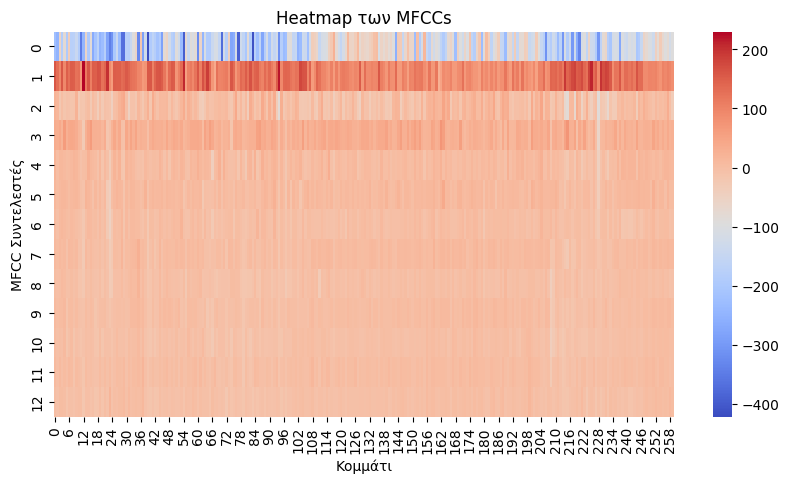

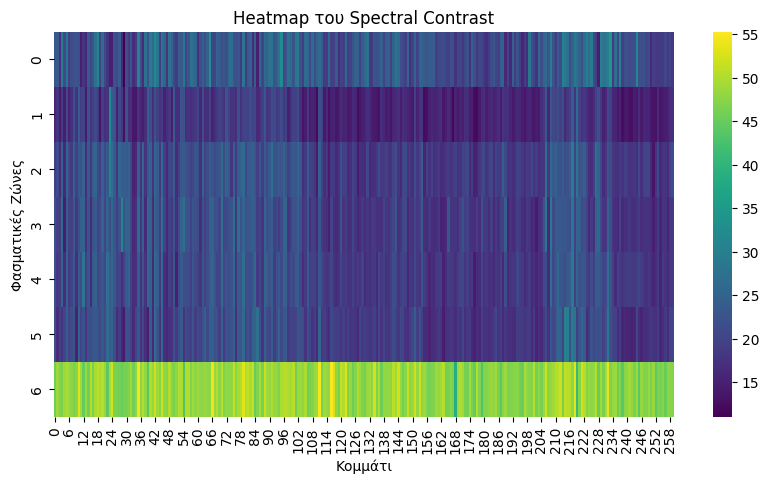

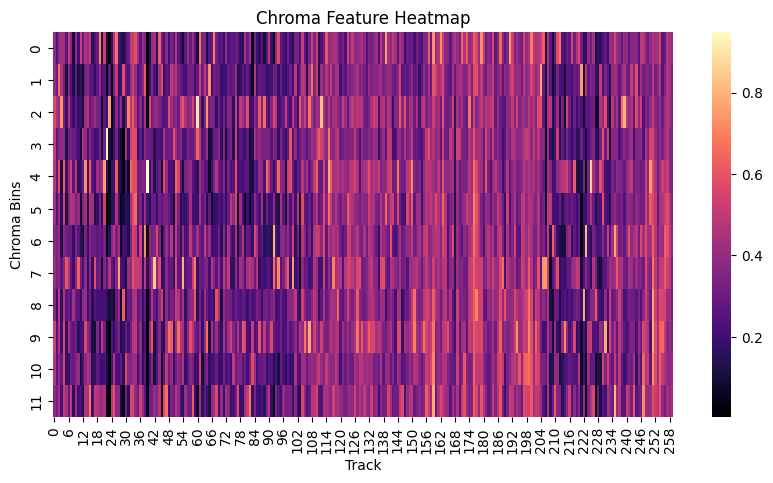

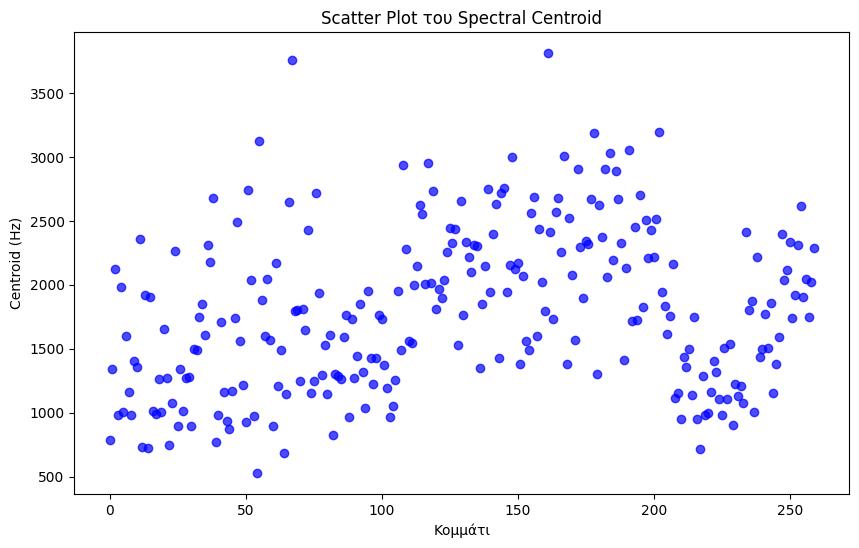

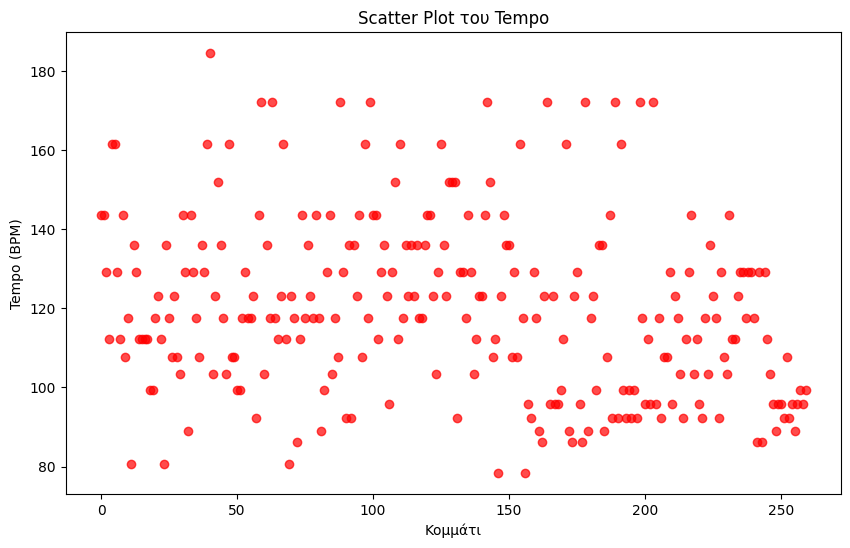

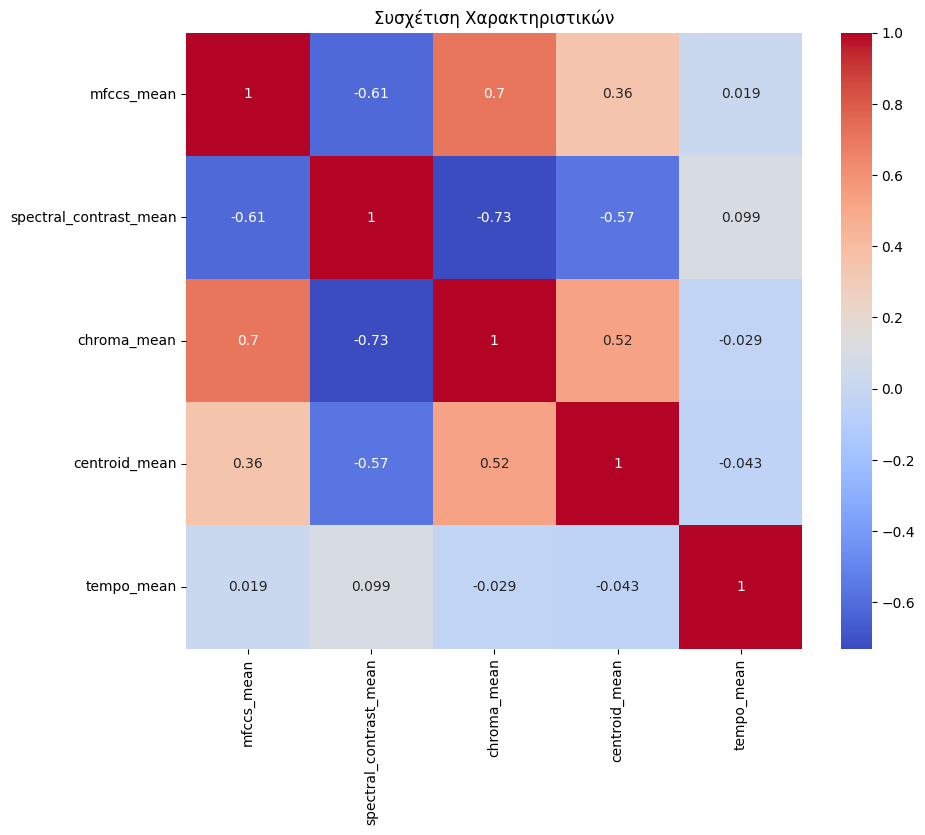

In [ ]:
# -------------------------- ΟΠΤΙΚΟΠΟΙΗΣΗ --------------------------

# Απεικόνιση των MFCCs σε ένα heatmap
plot_mfccs_heatmap(df_combined)

# Απεικόνιση του Spectral Contrast σε ένα heatmap
plot_spectral_contrast_heatmap(df_combined)

# Απεικόνιση των Chroma χαρακτηριστικών σε ένα heatmap
plot_chroma_heatmap(df_combined)

# Απεικόνιση του Spectral Centroid σε scatter plot
plot_centroid_scatter(df_combined)

# Απεικόνιση του Tempo σε scatter plot
plot_tempo_scatter(df_combined)

# Απεικόνιση της συσχέτισης μεταξύ των χαρακτηριστικών
plot_feature_correlation(df_combined, feature_columns)

In [ ]:
# -------------------------- ΜΟΝΤΕΛΟΠΟΙΗΣΗ --------------------------

# Συνένωση όλων των χαρακτηριστικών σε έναν πίνακα 
X = np.concatenate([np.vstack(df_combined[col].values) for col in feature_columns], axis=1)
y = df_combined['Genre']

# Διαχωρισμός των δεδομένων σε σύνολα train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Κανονικοποίηση των χαρακτηριστικών
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Μείωση των διαστάσεων με PCA
pca = PCA(n_components=15, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

KNN Classification Report:
              precision    recall  f1-score   support

        Folk       0.80      0.62      0.70        13
     Hip-Hop       0.92      0.85      0.88        13
Instrumental       0.71      0.92      0.80        13
        Rock       0.77      0.77      0.77        13

    accuracy                           0.79        52
   macro avg       0.80      0.79      0.79        52
weighted avg       0.80      0.79      0.79        52



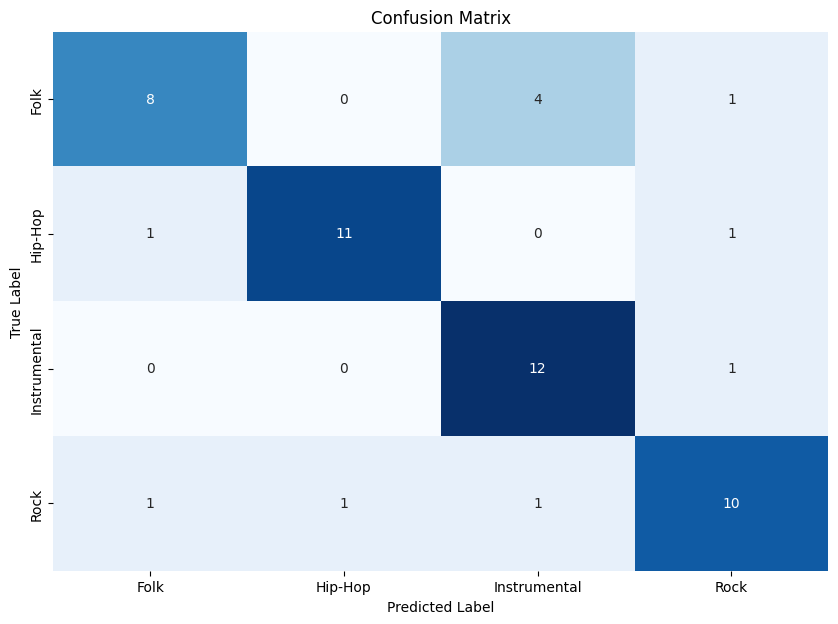

In [ ]:
# --- KNN ---
# Βελτιστοποίηση υπερπαραμέτρων για KNN με GridSearchCV
knn_param_grid = {'n_neighbors': [5, 10, 20, 30]}
knn_grid_search = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5, scoring='accuracy')
knn_grid_search.fit(X_train_pca, y_train)
best_knn_model = knn_grid_search.best_estimator_


y_pred_test_knn = best_knn_model.predict(X_test_pca)
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_test_knn))

# Απεικόνιση του CM για το KNN μοντέλο
cm_knn = confusion_matrix(y_test, y_pred_test_knn)
plot_confusion_matrix(cm_knn, classes=best_knn_model.classes_)

SVM Classification Report:
              precision    recall  f1-score   support

        Folk       0.89      0.62      0.73        13
     Hip-Hop       1.00      0.85      0.92        13
Instrumental       0.67      0.77      0.71        13
        Rock       0.76      1.00      0.87        13

    accuracy                           0.81        52
   macro avg       0.83      0.81      0.81        52
weighted avg       0.83      0.81      0.81        52



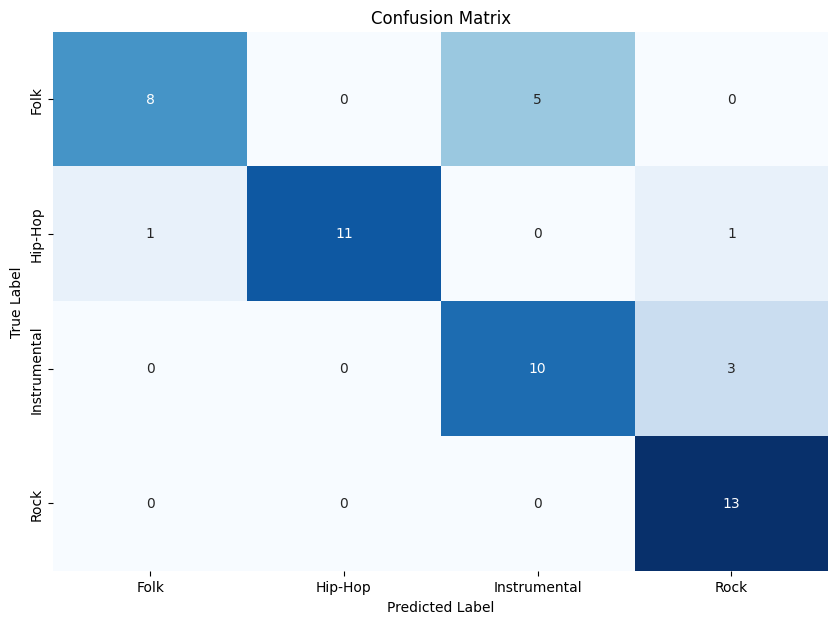

In [ ]:
# --- SVM ---
# Βελτιστοποίηση υπερπαραμέτρων για SVM με GridSearchCV
svm_param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'rbf', 'poly']}
svm_grid_search = GridSearchCV(SVC(probability=True), svm_param_grid, cv=5, scoring='accuracy')
svm_grid_search.fit(X_train_scaled, y_train)
best_svm_model = svm_grid_search.best_estimator_


y_pred_test_svm = best_svm_model.predict(X_test_scaled)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_test_svm))

# Απεικόνιση του CM για το SVM μοντέλο
cm_svm = confusion_matrix(y_test, y_pred_test_svm)
plot_confusion_matrix(cm_svm, classes=best_svm_model.classes_)

Random Forest Classification Report:
              precision    recall  f1-score   support

        Folk       0.75      0.69      0.72        13
     Hip-Hop       0.92      0.85      0.88        13
Instrumental       0.58      0.54      0.56        13
        Rock       0.69      0.85      0.76        13

    accuracy                           0.73        52
   macro avg       0.73      0.73      0.73        52
weighted avg       0.73      0.73      0.73        52



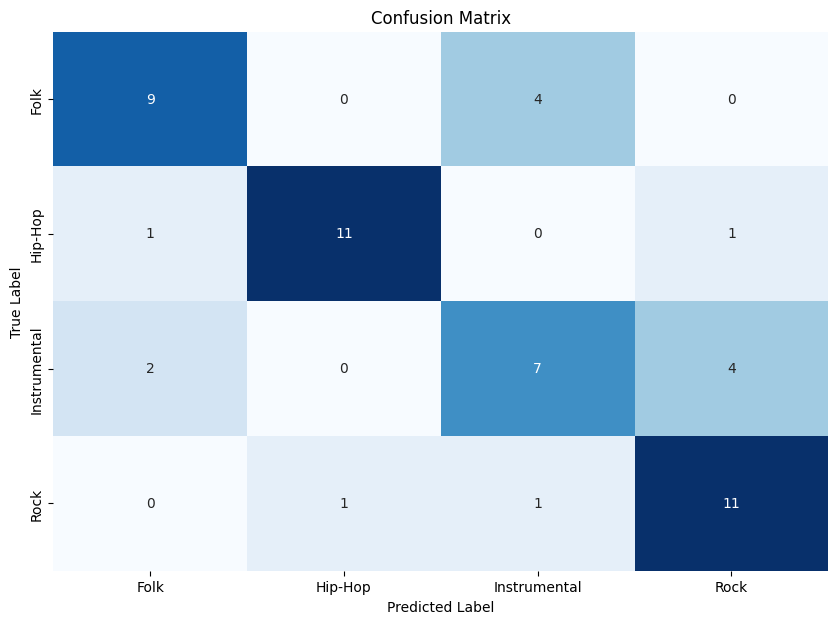

In [ ]:
# --- Random Forest ---
# Βελτιστοποίηση υπερπαραμέτρων για Random Forest με GridSearchCV
rf_param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='accuracy')
rf_grid_search.fit(X_train_scaled, y_train)
best_rf_model = rf_grid_search.best_estimator_


y_pred_test_rf = best_rf_model.predict(X_test_scaled)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_test_rf))

# Απεικόνιση του CM για το Random Forest μοντέλο
cm_rf = confusion_matrix(y_test, y_pred_test_rf)
plot_confusion_matrix(cm_rf, classes=best_rf_model.classes_)

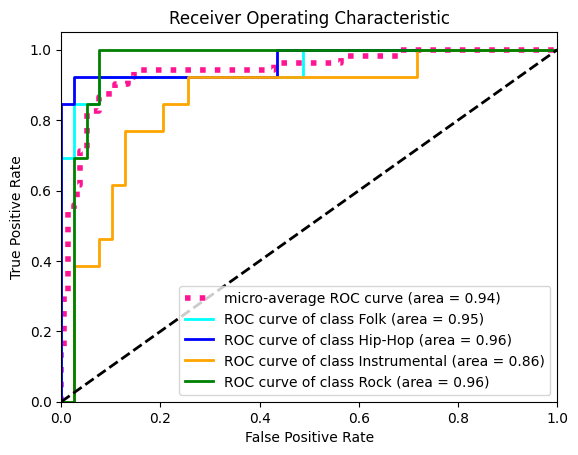

In [ ]:
# --- Απεικόνιση ROC Curve για το καλύτερο μοντέλο ---
y_score_svm = best_svm_model.predict_proba(X_test_scaled)
plot_multiclass_roc(y_test, y_score_svm, len(set(y_test)), np.unique(y_test))

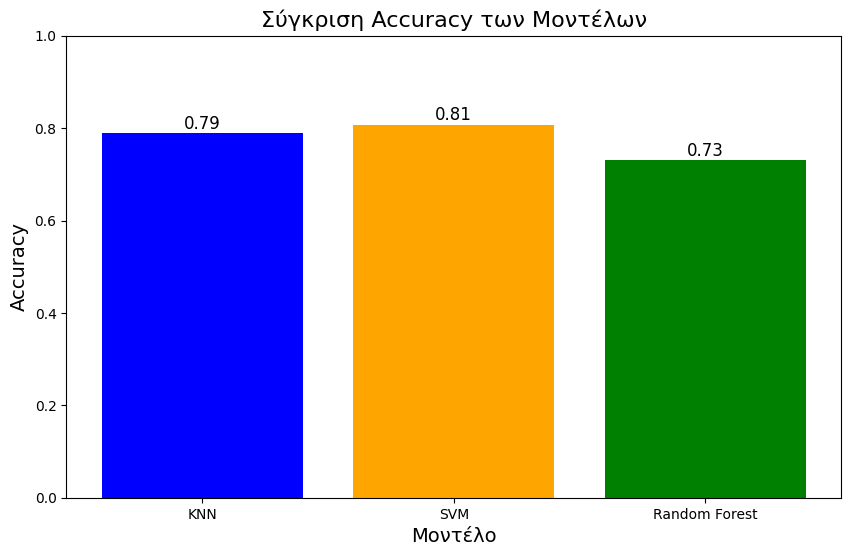

In [ ]:
# --- Σύγκριση Accuracy των Μοντέλων ---
accuracy_scores = {
    'KNN': accuracy_score(y_test, best_knn_model.predict(X_test_pca)),
    'SVM': accuracy_score(y_test, best_svm_model.predict(X_test_scaled)),
    'Random Forest': accuracy_score(y_test, best_rf_model.predict(X_test_scaled))
}

models = list(accuracy_scores.keys())
scores = list(accuracy_scores.values())

plt.figure(figsize=(10, 6))
plt.bar(models, scores, color=['blue', 'orange', 'green'])
plt.title('Σύγκριση Accuracy των Μοντέλων', fontsize=16)
plt.xlabel('Μοντέλο', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

for i in range(len(models)):
    plt.text(i, scores[i] + 0.01, f'{scores[i]:.2f}', ha='center', fontsize=12)

plt.ylim(0, 1)
plt.show()